In [9]:
%run ./tools.ipynb

In [10]:
month_strings = []
for i in range(1,13): month_strings.append(short_name_of_month(i))

In [11]:
mode = 'N'
top_dir = '/geos/u73/msadiq/GEOS-Chem/rundirs/ensemble_runs/'
mod_dir = top_dir + 'CO2-2018/nd51/'
monthly_adjustment = []

In [23]:
for imonth in range(1,13):

    name_month = short_name_of_month(imonth)
    ens_dir = top_dir + 'CO2-2018-' + month_string(imonth) + '/nd51/'
    
    if mode == 'N':
        delta_y0_file = 'delta_y0_model_N_' + str(imonth) + '.nc'
        xco2_file = 'XCO2_mod_and_oco2_N_' + name_month + '.nc'
    else:
        delta_y0_file = 'delta_y0_model_' + str(imonth) + '.nc'
        xco2_file = 'XCO2_mod_and_oco2_' + name_month + '.nc'
    # open datasets
    # ensemble runs
    ds_delta_y0 = xr.open_dataset(ens_dir + delta_y0_file)
    varnames = list(ds_delta_y0.data_vars.keys())  # list of variable name
    needed_vars = [i for i in varnames if i.startswith('X_SpeciesConc_CO2Tag')] # species var names
    # one-year run
    ds_xco2 = xr.open_dataset(mod_dir + xco2_file)
    xco2_oco2  = ds_xco2['xco2_oco2']
    xco2_model = ds_xco2['xco2_model']
    xco2_error = ds_xco2['xco2_error']
    diff = ds_xco2['xco2_oco2'] - ds_xco2['xco2_model']
    # reduce the size of all arrays and matrices, from 400k to <10k
    x = xco2_oco2.copy()
    x = x[np.logical_not(np.isnan(x))]
    ind = x.record.values   # index for slicing
    length = len(ind)
    # get a slice of arrays
    diff_slice = diff[ind].values
    xco2_error_slice = xco2_error[ind].values

    
    if imonth == 1:
        # a priori error
        del_X_f = np.zeros((22,22))
        for idiag in range(22):
            del_X_f[idiag,idiag] = 1.0  # assumed to be 1 TgC/yr
        # delta y0
        del_Y = np.empty((length,22))
        del_Y[:] = np.nan
        for itag, ivar in enumerate(needed_vars):
            del_Y[:,itag] = ds_delta_y0[ivar][ind].values

        # observation error
        obs_error = np.zeros((length,length))
        for idiag in range(length):
            obs_error[idiag, idiag] = xco2_error_slice[idiag]**2 + 2.5
            # measurment error from oco2
            # model error and representation error = 2.5 for land
        # calculation of first posterior
        del_Y_tran = np.matrix.transpose(del_Y)
        first      = np.matmul(del_Y,del_Y_tran)
        second     = np.linalg.inv(first+obs_error)
        third      = np.matmul(del_Y_tran,second)
        k_e        = np.matmul(del_X_f,third) # kalman gain,
        adjust     = np.matmul(k_e, diff_slice) # adjustment to prior
        print(short_name_of_month(imonth), ': ', sum(adjust))
        monthly_adjustment.append(sum(adjust))
        
    else:
        # update matrix
        fourth = np.identity(22) - np.matmul(third, del_Y)
        transform_mat = sp.sqrtm(fourth)
        del_X_a = np.matmul(del_X_f, transform_mat)
        del_X_f = del_X_a.copy()
    
        del_X_f_inv = np.linalg.inv(del_X_f)
        update = np.matmul(del_X_f_inv, del_X_f)
        
        # delta y0
        del_Y = np.empty((length,22))
        del_Y[:] = np.nan
        for itag, ivar in enumerate(needed_vars):
            del_Y[:,itag] = ds_delta_y0[ivar][ind].values
        del_Y = np.matmul(del_Y, update)
    
        # observation error
        obs_error = np.zeros((length,length))
        for idiag in range(length):
            obs_error[idiag, idiag] = xco2_error_slice[idiag]**2 + 2.5
            # measurment error from oco2
            # model error and representation error = 2.5 for land
            
        # calculation of posterior
        del_Y_tran = np.matrix.transpose(del_Y)
        first      = np.matmul(del_Y,del_Y_tran)
        second     = np.linalg.inv(first+obs_error)
        third      = np.matmul(del_Y_tran,second)
        k_e        = np.matmul(del_X_f,third)   # kalman gain,
        adjust     = np.matmul(k_e, diff_slice) # adjustment to prior
        print(short_name_of_month(imonth), ': ', sum(adjust))
        monthly_adjustment.append(sum(adjust))
print('Shape of (y_obs - H(x_f)):', np.shape(diff_slice)) 
print('Shape of K_e:', np.shape(k_e)) 
print('Shape of del_X_f:', np.shape(del_X_f)) 
print('Shape of del_Y:', np.shape(del_Y)) 
print('Shape of R:', np.shape(obs_error)) 
print('Shape of T:', np.shape(transform_mat)) 

Jan :  -0.010618586956054665
Feb :  0.0007398837859194096
Mar :  0.0004258824550283785
Apr :  -0.000817750923347571
May :  -0.0001586662041395126
Jun :  0.0002625673613056989
Jul :  0.00010355598966904633
Aug :  -1.4171897535553146e-05
Sep :  8.407307484656432e-06
Oct :  -4.323389101069594e-06
Nov :  1.7782143620797587e-06
Dec :  (-5.107502704495073e-07+1.1715081840783749e-08j)
Shape of (y_obs - H(x_f)): (1467,)
Shape of K_e: (22, 1467)
Shape of del_X_f: (22, 22)
Shape of del_Y: (1467, 22)
Shape of R: (1467, 1467)
Shape of T: (22, 22)


TypeError: Image data of dtype complex128 cannot be converted to float

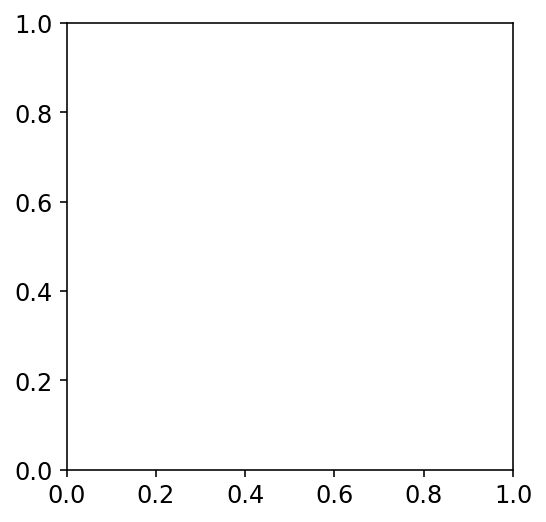

In [29]:
plt.matshow(del_Y)

In [13]:
net_flux_2018 = [1.6756097831727272,
 1.2130535711226365,
 1.1156644316039999,
 0.4589752591130908,
 -0.7041605208149091,
 -1.509181126397818,
 -0.8365738759716359,
 0.39889446111854543,
 1.202083570869818,
 1.5532087185410908,
 1.5974567518261815,
 1.9804034674403637]

In [14]:
adjusted = []
for i in range(len(net_flux_2018)):
    adjusted.append(net_flux_2018[i] + monthly_adjustment[i])

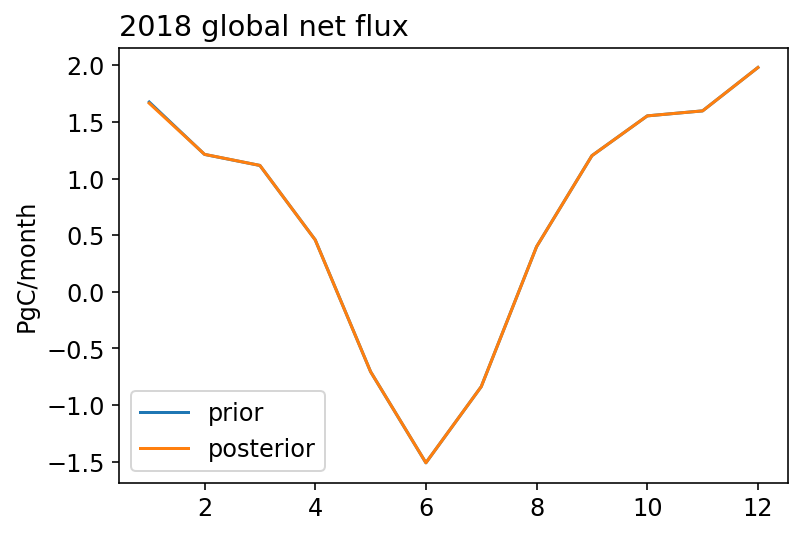

In [15]:
fig = plt.figure(figsize=[6, 4])
plt.plot(range(1,13), net_flux_2018, label = 'prior')
plt.plot(range(1,13), adjusted, label = 'posterior')
plt.title('2018 global net flux', loc='left')
plt.ylabel('PgC/month')
#plt.ylim(-2,2)
plt.legend()

#fig.savefig(output_dir + '/monthly_global.png', dpi = 300)

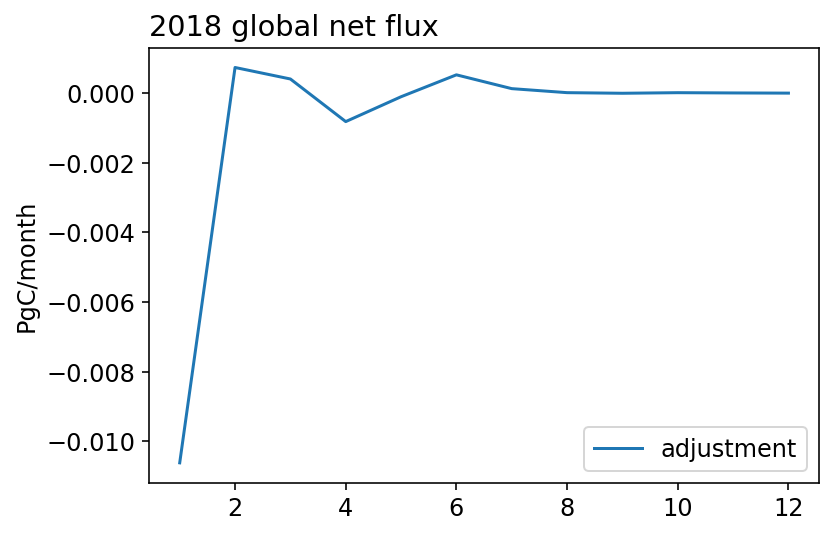

In [17]:
fig = plt.figure(figsize=[6, 4])
plt.plot(range(1,13), monthly_adjustment, label = 'adjustment')
plt.title('2018 global net flux', loc='left')
plt.ylabel('PgC/month')
plt.legend()